In [5]:
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
import torch.nn.functional as F
from tqdm import tqdm

import sys
sys.path.insert(0, '..')
from datasets import PneumaTrajectoryDataset

In [6]:
data =  PneumaTrajectoryDataset('merged.h5', n_samples=120, min_trajectory_length=5, max_trajectory_length=8, edge_format='srctar')

#for reproducibility
gen = torch.Generator().manual_seed(42)
train_data, val_data, test_data = torch.utils.data.random_split(data, [0.7, 0.15, 0.15], generator=gen)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=1)
valloader = torch.utils.data.DataLoader(val_data, batch_size=1)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [7]:
class SimpleGNN(torch.nn.Module):
	def __init__(self, node_features):
		super().__init__()
		self.conv1 = GCNConv(node_features+1, node_features)
		self.linear = torch.nn.Linear(node_features, 16)
		self.linear2 = torch.nn.Linear(16, 1)

	def forward(self, x, edge_index):

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		next_node = self.linear(x)
		next_node = F.relu(next_node)
		next_node = self.linear2(next_node)

		return x, next_node

In [13]:
feature_dim = 16
min_history = 3

model = SimpleGNN(data.graph.node_coordinates.shape[1] + feature_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_f = torch.nn.CrossEntropyLoss()

tlosses = []
taccuracies = []
vlosses = []
vaccuracies = []

In [14]:
local_loss = True

epochs = tqdm(range(30), desc='')
for epoch in epochs:
    model.train()
    epoch_accuracy = []
    epoch_loss = []
    for batch in trainloader:
        batch = batch.squeeze(0)
        mask = torch.arange(batch.shape[0]-min_history)[:, None]+min_history > torch.arange(batch.shape[0])
        for y_pos, m in enumerate(mask):
            x = batch[m]
            y = batch[min_history+y_pos]

            nfeatures = torch.tensor(data.graph.node_coordinates)
            nfeatures = torch.concat([nfeatures, torch.zeros(nfeatures.shape[0], feature_dim)], dim=1)
            for edge in x:
                on_path = torch.zeros(nfeatures.shape[0], 1)
                on_path[edge] = 1
                nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                nfeatures, next_node = model(nfeatures, data.graph.edge_index)
            
            last_node = x[-1][1].item()
            y_node = y[1].item()
            
            last_node_neighbors = list(data.graph.get_neighbors(last_node))
            neighbor_scores = next_node[last_node_neighbors]

            if local_loss:
                loss = loss_f(neighbor_scores.squeeze(1), torch.eye(len(last_node_neighbors))[last_node_neighbors.index(y_node)])
            else:
                loss = loss_f(next_node.squeeze(1), torch.tensor(y_node))
            epoch_accuracy.append(torch.mean((neighbor_scores.argmax(dim=0) == last_node_neighbors.index(y_node))*1.0))

            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

    taccuracies.append(np.array(epoch_accuracy).mean())
    tlosses.append(np.array(epoch_loss).mean())

    # Validation
    model.eval()
    epoch_accuracy = []
    epoch_loss = []
    for batch in valloader:
        batch = batch.squeeze(0)
        mask = torch.arange(batch.shape[0]-min_history)[:, None]+min_history > torch.arange(batch.shape[0])
        for y_pos, m in enumerate(mask):
            x = batch[m]
            y = batch[min_history+y_pos]

            nfeatures = torch.tensor(data.graph.node_coordinates)
            nfeatures = torch.concat([nfeatures, torch.zeros(nfeatures.shape[0], feature_dim)], dim=1)
            with torch.no_grad():
                for edge in x:
                    on_path = torch.zeros(nfeatures.shape[0], 1)
                    on_path[edge] = 1
                    nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                    nfeatures, next_node = model(nfeatures, data.graph.edge_index)
            
            last_node = x[-1][1].item()
            y_node = y[1].item()
            
            last_node_neighbors = list(data.graph.get_neighbors(last_node))
            neighbor_scores = next_node[last_node_neighbors]

            if local_loss:
                loss = loss_f(neighbor_scores.squeeze(1), torch.eye(len(last_node_neighbors))[last_node_neighbors.index(y_node)])
            else:
                loss = loss_f(next_node.squeeze(1), torch.tensor(y_node))

            epoch_accuracy.append(torch.mean((neighbor_scores.argmax(dim=0) == last_node_neighbors.index(y_node))*1.0))
            epoch_loss.append(loss.item())

    vaccuracies.append(np.array(epoch_accuracy).mean())
    vlosses.append(np.array(epoch_loss).mean())

    epochs.set_description(f"Train: {tlosses[-1]:.4f} {taccuracies[-1]:.3f}\tValidation: {vlosses[-1]:.4f} {vaccuracies[-1]:.3f}")

Train: 0.3262 0.907	Validation: 0.3450 0.844: 100%|██████████| 30/30 [01:56<00:00,  3.87s/it]


Text(0.5, 1.0, 'val accuracy')

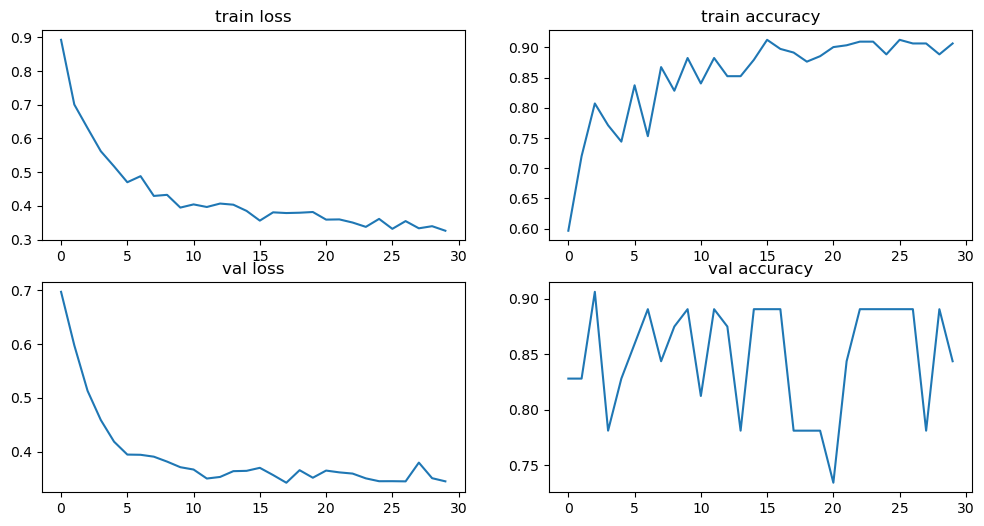

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].plot(np.arange(len(tlosses)), np.array(tlosses))
axs[0, 0].set_title("train loss")
axs[0, 1].plot(np.arange(len(taccuracies)), np.array(taccuracies))
axs[0, 1].set_title("train accuracy")

axs[1, 0].plot(np.arange(len(vlosses)), np.array(vlosses))
axs[1, 0].set_title("val loss")
axs[1, 1].plot(np.arange(len(vaccuracies)), np.array(vaccuracies))
axs[1, 1].set_title("val accuracy")

In [26]:
torch.save(model.state_dict(), "model.pt")
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [46]:
import torch
import numpy as np

def eval_n_step_accuracy(model, dataloader, n, graph, feature_dim, min_history=3, device=None):
    """
    Evaluate the n-step accuracy of a trajectory prediction model.

    Args:
        model (torch.nn.Module): The trajectory prediction model.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the trajectory data.
        n (int): The number of steps to predict into the future.
        min_history (int, optional): The minimum number of history steps required for prediction. Defaults to 3.

    Returns:
        numpy.ndarray: An array of n-step accuracies for each trajectory in the dataloader. If no trajectories meet the minimum history requirement, returns [-1].
    """
    model.eval()

    accuracies = []
    for batch in dataloader:
        batch = batch.squeeze(0)
        if batch.shape[0]-min_history-n <= 0:
            continue
        mask = torch.arange(batch.shape[0]-min_history-n, device=device)[:, None]+min_history > torch.arange(batch.shape[0], device=device)
        for y_pos, m in enumerate(mask):
            x = batch[m]
            y = batch[min_history+y_pos]

            # Convert numpy array to torch tensor
            nfeatures = torch.tensor(graph.node_coordinates, device=device)

            # Then concatenate
            nfeatures = torch.concat([nfeatures, torch.zeros(nfeatures.shape[0], feature_dim, device=device)], dim=1)

            # nfeatures = graph.node_coordinates
            # nfeatures = torch.concat([nfeatures, torch.zeros(nfeatures.shape[0], feature_dim, device=device)], dim=1)
            with torch.no_grad():
                # Follow trajectory
                for edge in x:
                    on_path = torch.zeros(nfeatures.shape[0], 1, device=device)
                    on_path[edge] = 1
                    nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                    nfeatures, next_node = model(nfeatures, graph.edge_index)

                # Predict "on its own"
                last_node = x[-1][1].item()
                for _ in range(n):
                    last_node_neighbors = list(graph.get_neighbors(last_node))
                    neighbor_scores = next_node[last_node_neighbors]
                    predicted_node = last_node_neighbors[neighbor_scores.argmax(dim=0)]
                    predicted_edge = torch.tensor([last_node, predicted_node])
                    last_node = predicted_node

                    on_path = torch.zeros(nfeatures.shape[0], 1, device=device)
                    on_path[predicted_edge] = 1
                    nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                    nfeatures, next_node = model(nfeatures, graph.edge_index)


            last_node = x[-1][1].item()
            y_node = y[1].item()

            last_node_neighbors = list(graph.get_neighbors(last_node))
            neighbor_scores = next_node[last_node_neighbors]

            accuracies.append(torch.mean((neighbor_scores.argmax(dim=0) == last_node_neighbors.index(y_node))*1.0).cpu().item())

    if len(accuracies) == 0:
        return np.array([-1])
    return np.array(accuracies)

def eval_n_step_distance(model, dataloader, n, graph, feature_dim, min_history=3, device=None):
    """
    Evaluate the n-step (euclidean) distance error of a trajectory prediction model.

    Args:
        model (torch.nn.Module): The trajectory prediction model.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the trajectory data.
        n (int): The number of steps to predict into the future.
        min_history (int, optional): The minimum number of history steps required for prediction. Defaults to 3.

    Returns:
        numpy.ndarray: An array of n-step distance error for each trajectory in the dataloader. If no trajectories meet the minimum history requirement, returns [-1].
    """
    model.eval()

    distances = []
    for batch in dataloader:
        batch = batch.squeeze(0)
        if batch.shape[0]-min_history-n <= 0:
            continue
        mask = torch.arange(batch.shape[0]-min_history-n, device=device)[:, None]+min_history > torch.arange(batch.shape[0], device=device)
        for y_pos, m in enumerate(mask):
            x = batch[m]
            y = batch[min_history+y_pos]

            # Convert numpy array to torch tensor
            nfeatures = torch.tensor(graph.node_coordinates, device=device)

            # Then concatenate
            nfeatures = torch.concat([nfeatures, torch.zeros(nfeatures.shape[0], feature_dim, device=device)], dim=1)
            
            
            
            with torch.no_grad():
                # Follow trajectory
                for edge in x:
                    on_path = torch.zeros(nfeatures.shape[0], 1, device=device)
                    on_path[edge] = 1
                    nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                    nfeatures, next_node = model(nfeatures, graph.edge_index)
                
                # Predict "on its own"
                last_node = x[-1][1].item()
                for _ in range(n):
                    last_node_neighbors = list(graph.get_neighbors(last_node))
                    neighbor_scores = next_node[last_node_neighbors]
                    predicted_node = last_node_neighbors[neighbor_scores.argmax(dim=0)]
                    predicted_edge = torch.tensor([last_node, predicted_node])
                    last_node = predicted_node

                    on_path = torch.zeros(nfeatures.shape[0], 1, device=device)
                    on_path[predicted_edge] = 1
                    nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                    nfeatures, next_node = model(nfeatures, graph.edge_index)

            
            last_node = x[-1][1].item()
            y_node = y[1].item()
            
            last_node_neighbors = list(graph.get_neighbors(last_node))
            neighbor_scores = next_node[last_node_neighbors]
            
            distances.append(np.linalg.norm(graph.node_coordinates[neighbor_scores.argmax(dim=0).numpy()] - graph.node_coordinates[last_node_neighbors.index(y_node)]))

    if len(distances) == 0:
        return np.array([-1])
    return np.array(distances)

In [36]:
for n in range(0, 10):
    print(f"n={n}: {eval_n_step_accuracy(model, testloader, n, data.graph, feature_dim, min_history=3).mean()}")

n=0: 0.8028169014084507
n=1: 0.5283018867924528
n=2: 0.2571428571428571
n=3: 0.0
n=4: 0.0
n=5: -1.0
n=6: -1.0
n=7: -1.0
n=8: -1.0
n=9: -1.0


In [47]:
for n in range(0, 10):
    print(f"n={n}: {eval_n_step_distance(model, testloader, n, data.graph, feature_dim, min_history=3).mean()}")

n=0: 0.009894627523836885
n=1: 0.030522174767840707
n=2: 0.05315427190604586
n=3: 0.0756377430489337
n=4: 0.09085321615412355
n=5: -1.0
n=6: -1.0
n=7: -1.0
n=8: -1.0
n=9: -1.0
